Performed for PM2.5 Maintenance area of Pierce County. The plot below shows the geographic extent of the area. This is used to summarize running emissions. Emissions totals are calculated using the same process as regional emissions. 

Pierce County start emissions are scaled based on the VMT in the maintenance area versus VMT for Pierce County.

In [1]:
import geopandas as gpd
import pandas as pd
import polars as pl
from pathlib import Path
import util

pd.set_option('display.float_format', '{:,.1f}'.format)

root_dir = Path('../../../..')

In [2]:
# The set of functions below are used for a variety of calculations. 
# These are adapted from the main emissions.py script used calculate regional emissions

In [3]:
taz_gdf = gpd.read_file(util.input_path / "base_year/taz2010.geojson")
taz_gdf = taz_gdf.to_crs(2285)

In [4]:
def grams_to_tons(value):
    """Convert grams to tons."""

    value = value / 453.592
    value = value / 2000

    return value


def calculate_interzonal_vmt(df):
    """Calcualte inter-zonal running emission rates from network outputs. 
       Input: network_results data
    """

    # List of vehicle types to include in results; note that bus is included here but not for intrazonals
    vehicle_type_list = ["sov", "hov2", "hov3", "bus", "medium_truck", "heavy_truck"]

    # Load link-level volumes by time of day
    # df = pd.read_csv(Path(root_dir, "outputs/network/network_results.csv"))

    # Remove links with facility type = 0 from the calculation
    df["facility_type"] = df["data3"].copy()  # Rename for human readability
    df = df[df["facility_type"] > 0]

    # Calculate VMT by bus, SOV, HOV2, HOV3+, medium truck, heavy truck
    df["sov_vol"] = df["@sov_inc1"] + df["@sov_inc2"] + df["@sov_inc3"]
    df["sov_vmt"] = df["sov_vol"] * df["length"]
    df["hov2_vol"] = df["@hov2_inc1"] + df["@hov2_inc2"] + df["@hov2_inc3"]
    df["hov2_vmt"] = df["hov2_vol"] * df["length"]
    df["hov3_vol"] = df["@hov3_inc1"] + df["@hov3_inc2"] + df["@hov3_inc3"]
    df["hov3_vmt"] = df["hov3_vol"] * df["length"]
    if util.input_config["include_tnc_emissions"]:
        df["tnc_vmt"] = df["@tnc_inc1"] + df["@tnc_inc2"] + df["@tnc_inc3"]
    else:
        df["tnc_vmt"] = 0
    df["bus_vmt"] = df["@bveh"] * df["length"]
    df["medium_truck_vmt"] = df["@mveh"] * df["length"]
    df["heavy_truck_vmt"] = df["@hveh"] * df["length"]

    # Convert TOD periods into hours used in emission rate files
    df["hourId"] = df["tod"].map(util.summary_config["tod_lookup"]).astype("int")

    # Calculate congested speed to separate time-of-day link results into speed bins
    df["congested_speed"] = (df["length"] / df["auto_time"]) * 60
    df["avgspeedbinId"] = pd.cut(
        df["congested_speed"],
        util.summary_config["speed_bins"],
        labels=range(1, len(util.summary_config["speed_bins"])),
    ).astype("int")

    # Relate soundcast facility types to emission rate definitions (e.g., minor arterial, freeway)
    df["roadtypeId"] = (
        df["facility_type"]
        .map({int(k): v for k, v in util.summary_config["fac_type_lookup"].items()})
        .astype("int")
    )

    # Take total across columns where distinct emission rate are available
    # This calculates total VMT, by vehicle type (e.g., HOV3 VMT for hour 8, freeway, 55-59 mph)
    join_cols = ["avgspeedbinId", "roadtypeId", "hourId"]
    df = df.groupby(join_cols).sum()
    df = df[
        [
            "sov_vmt",
            "hov2_vmt",
            "hov3_vmt",
            "tnc_vmt",
            "bus_vmt",
            "medium_truck_vmt",
            "heavy_truck_vmt",
        ]
    ]
    df = df.reset_index()

    # Write this file for calculation with different emission rates
    df.to_csv(root_dir / "outputs/emissions/conformity/interzonal_vmt_grouped.csv", index=False)

    return df

def finalize_emissions(df, col_suffix=""):
    """
    Compute PM10 and PM2.5 totals, sort index by pollutant value, and pollutant name.
    For total columns add col_suffix (e.g., col_suffix='intrazonal_tons')
    """

    pm10 = (
        df[df["pollutantID"].isin([100, 106, 107])]
        .groupby("veh_type")
        .sum()
        .reset_index()
    )
    pm10["pollutantID"] = "PM10"
    pm25 = (
        df[df["pollutantID"].isin([110, 116, 117])]
        .groupby("veh_type")
        .sum()
        .reset_index()
    )
    pm25["pollutantID"] = "PM25"
    df = pd.concat([df, pm10])
    df = pd.concat([df, pm25])

    return df


def calculate_interzonal_emissions(df, df_rates):
    """Calculate link emissions using rates unique to speed, road type, hour, and vehicle type."""

    df.rename(
        columns={
            "avgspeedbinId": "avgSpeedBinID",
            "roadtypeId": "roadTypeID",
            "hourId": "hourID",
        },
        inplace=True,
    )

    # Calculate total VMT by vehicle group
    df["light"] = df["sov_vmt"] + df["hov2_vmt"] + df["hov3_vmt"] + df["tnc_vmt"]
    df["medium"] = df["medium_truck_vmt"]
    df["heavy"] = df["heavy_truck_vmt"]
    df["transit"] = df["bus_vmt"]
    # What about buses??
    df.drop(
        [
            "sov_vmt",
            "hov2_vmt",
            "hov3_vmt",
            "tnc_vmt",
            "medium_truck_vmt",
            "heavy_truck_vmt",
            "bus_vmt",
        ],
        inplace=True,
        axis=1,
    )

    # Melt to pivot vmt by vehicle type columns as rows
    df = pd.melt(
        df,
        id_vars=["avgSpeedBinID", "roadTypeID", "hourID"],
        var_name="veh_type",
        value_name="vmt",
    )

    df = pd.merge(
        df,
        df_rates,
        on=["avgSpeedBinID", "roadTypeID", "hourID", "veh_type"],
        how="left",
        left_index=False,
    )
    # Calculate total grams of emission
    df["grams_tot"] = df["grams_per_mile"] * df["vmt"]
    df["tons_tot"] = grams_to_tons(df["grams_tot"])

    df.to_csv(root_dir / "outputs/emissions/conformity/interzonal_emissions.csv", index=False)

    return df


def calculate_intrazonal_vmt():
    df_iz = pd.read_csv(util.output_path / "network/iz_vol.csv")

    # Sum up SOV, HOV2, and HOV3 volumes across user classes 1, 2, and 3 by time of day
    df_results = pd.DataFrame()
    for tod in util.summary_config["tod_lookup"].keys():
        df = pd.DataFrame()
        df["taz"] = df_iz['taz']
        df["sov"] = df_iz[["sov_inc1_" + tod,"sov_inc2_" + tod,"sov_inc3_" + tod]].sum(axis=1)
        df["hov2"] = df_iz[["hov2_inc1_" + tod,"hov2_inc2_" + tod,"hov2_inc3_" + tod]].sum(axis=1)
        df["hov3"] = df_iz[["hov3_inc1_" + tod,"hov3_inc2_" + tod,"hov3_inc3_" + tod]].sum(axis=1)
        df["mediumtruck"] = df_iz[["medium_truck_" + tod]].copy()
        df["heavytruck"] = df_iz["heavy_truck_" + tod].copy()
        df["tod"] = tod

        df_results = pd.concat([df_results, df])

    df = pd.melt(
        df_results,
        value_vars=["sov", "hov2", "hov3", "mediumtruck", "heavytruck"],
        id_vars=["taz","tod"],
        var_name="vehicle_type",
        value_name="vol",
    )

    # Calculate VMT from zonal distance and volume
    df = df.merge(
        df_iz[["taz", "izdist"]], how="left", on="taz"
    )
    df['VMT'] = df['vol'] * df['izdist']
    df = df.groupby(['tod','vehicle_type']).sum()[['VMT']].reset_index()
    # Use hourly periods from emission rate files
    df["hourId"] = df["tod"].map(util.summary_config["tod_lookup"]).astype("int")
    
    # Export this file for use with other rate calculations
    # Includes total VMT for each group for which rates are available
    df = df[['VMT','tod','vehicle_type','hourId']]
    df.to_csv(root_dir / "outputs/emissions/conformity/intrazonal_vmt_grouped.csv", index=False)

    return df


def calculate_intrazonal_emissions(df_running_rates):
    """Summarize intrazonal emissions by vehicle type."""

    df_intra = pd.read_csv(root_dir / "outputs/emissions/conformity/intrazonal_vmt_grouped.csv")
    df_intra.rename(
        columns={
            "vehicle_type": "veh_type",
            "VMT": "vmt",
            "hourId": "hourID",
        },
        inplace=True,
    )
    df_intra.drop("tod", axis=1, inplace=True)

    df_intra_light = df_intra[df_intra["veh_type"].isin(["sov", "hov2", "hov3"])]
    df_intra_light = (
        df_intra_light.groupby(["hourID"]).sum()[["vmt"]].reset_index()
    )
    df_intra_light.loc[:, "veh_type"] = "light"

    df_intra_medium = df_intra[df_intra["veh_type"] == "mediumtruck"]
    df_intra_medium.loc[:, "veh_type"] = "medium"
    df_intra_heavy = df_intra[df_intra["veh_type"] == "heavytruck"]
    df_intra_heavy.loc[:, "veh_type"] = "heavy"

    df_intra = pd.concat([df_intra_light, df_intra_medium])
    df_intra = pd.concat([df_intra, df_intra_heavy])

    # For intrazonals, assume standard speed bin and roadway type for all intrazonal trips
    speedbin = 4
    roadtype = 5

    iz_rates = df_running_rates[
        (df_running_rates["avgSpeedBinID"] == speedbin)
        & (df_running_rates["roadTypeID"] == roadtype)
    ]

    df_intra = pd.merge(
        df_intra,
        iz_rates,
        on=["hourID", "veh_type"],
        how="left",
        left_index=False,
    )

    # Calculate total grams of emission
    df_intra["grams_tot"] = df_intra["grams_per_mile"] * df_intra["vmt"]
    df_intra["tons_tot"] = grams_to_tons(df_intra["grams_tot"])

    # Write raw output to file
    df_intra.to_csv(root_dir / "outputs/emissions/conformity/intrazonal_emissions.csv", index=False)

    return df_intra


def calculate_start_emissions():
    """Calculate start emissions based on vehicle population by year."""

    df_veh = util.read_sqlite_db(
        "SELECT * FROM vehicle_population WHERE year=="
        + util.input_config["base_year"]
    )
    df_veh = df_veh.groupby(['type']).sum()[['vehicles']].reset_index()

    # Scale all vehicles by difference between base year and model total vehicles owned from auto ownership model
    df_hh = pl.read_csv(util.output_path/"daysim/_household.tsv", separator="\t")
    tot_veh = df_hh["hhvehs"].sum()

    # Scale vehicles by change in household vehicle ownership model versus base year
    veh_scale = 1.0 + (tot_veh - util.summary_config["tot_veh_model_base_year"]) / util.summary_config["tot_veh_model_base_year"]
    df_veh["vehicles"] = df_veh["vehicles"] * veh_scale

    # Join with rates to calculate total emissions
    start_rates_df = load_starting_rates()

    # Select winter rates for pollutants other than those listed in summer_list
    df_summer = start_rates_df[
        start_rates_df["pollutantID"].isin(util.summary_config["summer_list"])
    ].copy()
    df_summer = df_summer[df_summer["monthID"] == 7].copy()
    df_winter = start_rates_df[
        ~start_rates_df["pollutantID"].isin(util.summary_config["summer_list"])
    ].copy()
    df_winter = df_winter[df_winter["monthID"] == 1].copy()
    start_rates_df = pd.concat([df_winter, df_summer])

    # Sum total emissions across all times of day, by county, for each pollutant
    start_rates_df = (
        start_rates_df.groupby(["pollutantID", "veh_type"])
        .sum()[["ratePerVehicle"]]
        .reset_index()
    )

    df = pd.merge(
        df_veh,
        start_rates_df,
        left_on=["type"],
        right_on=["veh_type"],
    )
    df["start_grams"] = df["vehicles"] * df["ratePerVehicle"]
    df["start_tons"] = grams_to_tons(df["start_grams"])
    df = df.groupby(["pollutantID", "veh_type"]).sum().reset_index()

    # Calculate bus start emissions
    # Load data taken from NTD that reports number of bus vehicles "operated in maximum service"
    df_bus_veh = util.read_sqlite_db("SELECT * FROM bus_vehicles WHERE year==" + util.input_config["base_year"])
    tot_buses = df_bus_veh["bus_vehicles_in_service"].sum()

    df_bus = start_rates_df[start_rates_df["veh_type"] == "transit"].copy()
    df_bus["start_grams"] = df_bus["ratePerVehicle"] * tot_buses
    df_bus["start_tons"] = grams_to_tons(df_bus["start_grams"])
    df_bus["veh_type"] = "transit"

    df = pd.concat([df, df_bus])

    df.to_csv(root_dir / "outputs/emissions/conformity/start_emissions.csv", index=False)

    return df

def load_starting_rates():
    """Load starting emission rates by vehicle type, for the model year"""

    if util.summary_config["emissions_scenario"] == "standard":
        df_starting_rates = util.read_sqlite_db("SELECT * FROM start_emission_rates_by_veh_type WHERE year==" + util.input_config["model_year"])
        print("Using standard start rates.")
    else:
        df_starting_rates = pd.read_csv(Path(util.summary_config["emissions_scenario"]) / "start_emission_rates_by_veh_type.csv")
        df_starting_rates = df_starting_rates[df_starting_rates['year'] == int(util.input_config["model_year"])]
        print("Using scenario start rates specified in summary_configuration.toml.")

    return df_starting_rates

In [5]:
# Load the PM2.5 conformity shapefile
gdf_pm25 = gpd.read_file(r'X:\Trans\TIP\AIRQUAL\Conformity\pm25_harn.shp')
gdf_pm25 = gdf_pm25.to_crs(2285)

PM2.5 Maintenance Area 

<Axes: >

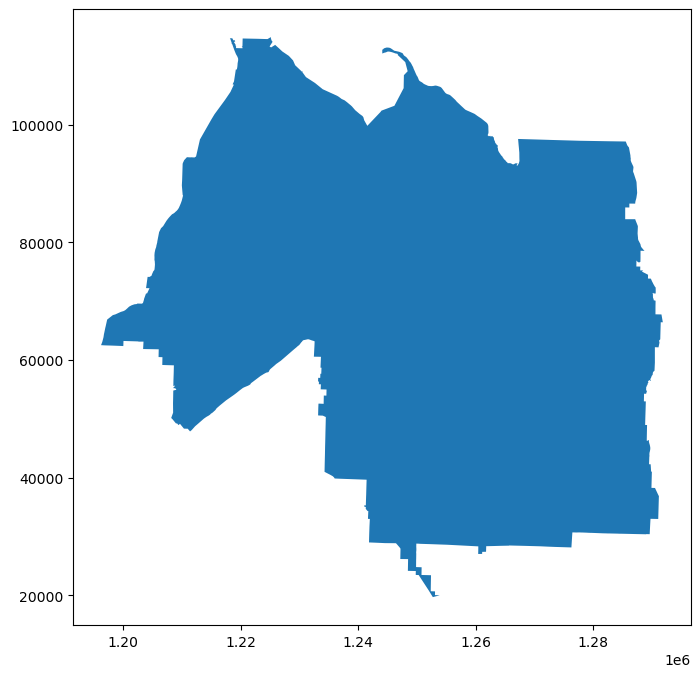

In [6]:
gdf_pm25.plot(figsize=(8,8))

In [7]:
# Load network shapefile to intersect network with conformity areas
gdf_network = gpd.read_file(util.input_path / 'scenario/networks/shapefiles/AM/AM_edges.shp')

# Intersect network links with conformity geography
gdf_intersect = gpd.overlay(gdf_network, gdf_pm25, how="intersection")

In [8]:
# gdf_network['link_id']

In [9]:
# intesect conformity area with TAZ file to get list of TAZs for intrazonal calculations
taz_maint = gpd.overlay(gdf_pm25, taz_gdf, how="intersection")

In [10]:
# taz_maint

TAZs in Maintenance Area. The intrazonal emissions totals will be included for these TAZs

<Axes: >

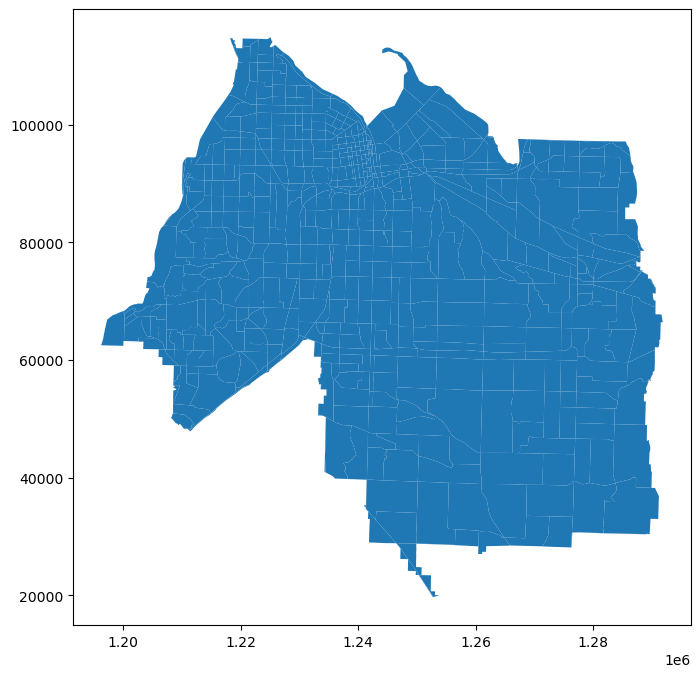

In [11]:
taz_maint.plot(figsize=(8,8))

Network within PM2.5 Maintenance Area.

These network links are used to calculate running (interzonal) emissions totals.

<Axes: >

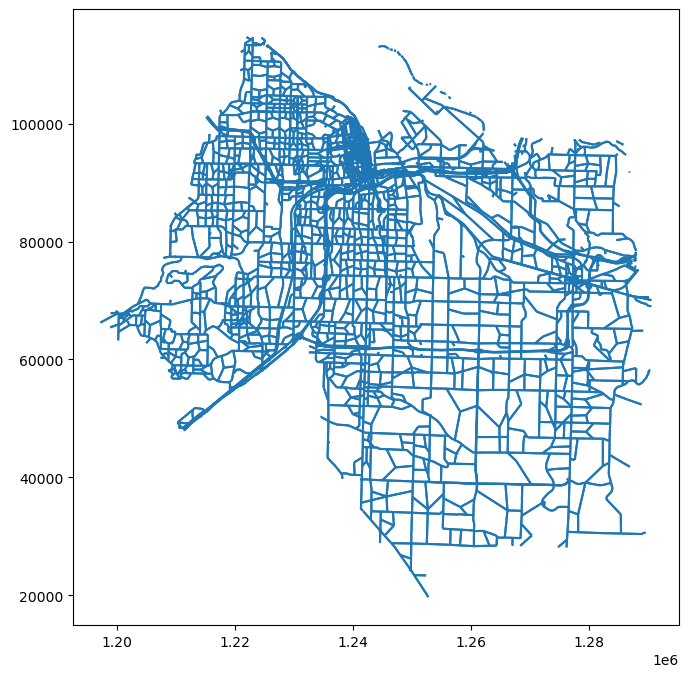

In [12]:
gdf_intersect.plot(figsize=(8,8))

In [13]:
# Load network results with data on VMT, speed, facility type, etc. 
network_df = util.process_network_summary()

In [14]:
# Join network data to the PM2.5 maintenance area network
network_pm25_df = gdf_intersect[['link_id']].merge(network_df, left_on='link_id', right_on='ij')

In [15]:
# Create output subdirectory for conformity emissions results 
conformity_dir = root_dir / 'outputs/emissions/conformity'
if not conformity_dir.is_dir():
    conformity_dir.mkdir()


In [16]:
# Load running emission rates by vehicle type, for the model year
df_running_rates = util.read_sqlite_db('SELECT * FROM running_emission_rates_by_veh_type WHERE year=='+util.input_config['model_year'])
df_running_rates.rename(columns={'ratePerDistance': 'grams_per_mile'}, inplace=True)
df_running_rates['year'] = df_running_rates['year'].astype('str')

# Select the month to use for each pollutant; some rates are used for winter or summer depending
# on when the impacts are at a maximum due to temperature.
df_summer = df_running_rates[df_running_rates['pollutantID'].isin(util.summary_config['summer_list'])]
df_summer = df_summer[df_summer['monthID'] == 7]
df_winter = df_running_rates[~df_running_rates['pollutantID'].isin(util.summary_config['summer_list'])]
df_winter = df_winter[df_winter['monthID'] == 1]
df_running_rates = pd.concat([df_winter,df_summer])

# Group interzonal trips and calculate interzonal emissions
df_interzonal_vmt = calculate_interzonal_vmt(network_pm25_df)
df_interzonal = calculate_interzonal_emissions(df_interzonal_vmt, df_running_rates)

In [17]:
# Calculate start emissions by vehicle type
start_emissions_df = calculate_start_emissions()

Using standard start rates.


In [18]:


# # Select only emissions for Pierce County, the location of the maintenance area
# start_emissions_df = start_emissions_df[start_emissions_df['county'] == 'pierce'].copy()

# we need to apply a scaling factor to represent only the study area
# In previous analyses we used % VMT in the study area compared to region overall

# calculate total VMT in the maintenance area
network_pm25_df['VMT'] = network_pm25_df['@tveh']*network_pm25_df['length']
maint_vmt = network_pm25_df['VMT'].sum()

# Apply county names
county_id_lookup = {
    33: 'king',
    35: 'kitsap',
    53: 'pierce',
    61: 'snohomish'
}

# Calculate total VMT for pierce county
network_df['VMT'] = network_df['@tveh']*network_df['length']
tot_vmt = network_df['VMT'].sum()

starts_scaling_factor = maint_vmt/tot_vmt

# Apply scaling factor to the starts emissions totals
start_emissions_df['start_tons'] = start_emissions_df['start_tons']*starts_scaling_factor

In [19]:
# Group intrazonal trips and calculate intrazonal emissions
df_intrazonal_vmt = calculate_intrazonal_vmt()
df_intrazonal = calculate_intrazonal_emissions(df_running_rates)

# Combine all rates and export as CSV
df_inter_group = df_interzonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_inter_group.rename(columns={'tons_tot': 'interzonal_tons'}, inplace=True)
df_intra_group = df_intrazonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_intra_group.rename(columns={'tons_tot': 'intrazonal_tons'}, inplace=True)
df_start_group = start_emissions_df.groupby(['pollutantID','veh_type']).sum()[['start_tons']].reset_index()

summary_df = pd.merge(df_inter_group, df_intra_group)
summary_df = pd.merge(summary_df, df_start_group, how='left')
summary_df = finalize_emissions(summary_df, col_suffix="")
summary_df.loc[~summary_df['pollutantID'].isin(['PM','PM10','PM25']),'pollutantID'] = summary_df[~summary_df['pollutantID'].isin(['PM','PM10','PM25'])]['pollutantID'].astype('int')
summary_df['pollutant_name'] = summary_df['pollutantID'].astype('int', errors='ignore').astype('str').map(util.summary_config['pollutant_map'])
summary_df['total_daily_tons'] = summary_df['start_tons']+summary_df['interzonal_tons']+summary_df['intrazonal_tons']
summary_df = summary_df[['pollutantID','pollutant_name','veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
summary_df.to_csv(root_dir / 'outputs/emissions/conformity/emissions_summary.csv',index=False)

## PM2.5
Tons

In [20]:
df = summary_df[summary_df['pollutant_name'] == 'PM25 Total']
df = df[['veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
df.index = df['veh_type']
df[['start_tons','intrazonal_tons','total_daily_tons']]

,start_tons,intrazonal_tons,total_daily_tons
veh_type,,,
heavy,0.0,0.0,0.0
light,0.0,0.0,0.1
medium,0.0,0.0,0.0


Pounds in Maintenance Area

In [21]:
df_lbs = df[['start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]*2000
df_lbs.rename(columns={'start_tons': 'start_pounds', 'intrazonal_tons': 'intrazonal_pounds', 
                       'total_daily_tons': 'total_daily_pounds', 'interzonal_tons': 'interzonal_pounds'}, inplace=True)

In [22]:
df_lbs

,start_pounds,intrazonal_pounds,interzonal_pounds,total_daily_pounds
veh_type,,,,
heavy,0.0,0.3,25.1,25.5
light,15.5,15.5,176.8,207.9
medium,3.2,0.2,12.3,15.7


Total Pounds in Mainentance Area

In [23]:
df_lbs['total_daily_pounds'].sum()

np.float64(249.04981319446009)

## NOx
Tons in Maintenance Area

In [24]:
df = summary_df[summary_df['pollutant_name'] == 'NOx']
df = df[['veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
df.index = df['veh_type']
df[['start_tons','intrazonal_tons','total_daily_tons']]

,start_tons,intrazonal_tons,total_daily_tons
veh_type,,,
heavy,0.0,0.0,0.4
light,0.1,0.0,0.1
medium,0.0,0.0,0.1


Pounds in Maintenance Area

In [25]:
df_lbs = df[['start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]*2000
df_lbs.rename(columns={'start_tons': 'start_pounds', 'intrazonal_tons': 'intrazonal_pounds', 
                       'total_daily_tons': 'total_daily_pounds', 'interzonal_tons': 'interzonal_pounds'}, inplace=True)

In [26]:
df_lbs

,start_pounds,intrazonal_pounds,interzonal_pounds,total_daily_pounds
veh_type,,,,
heavy,4.3,7.3,882.6,894.2
light,117.7,4.9,101.1,223.7
medium,88.0,1.0,69.3,158.4


Total Pounds in Maitenance Area

In [27]:
df_lbs['total_daily_pounds'].sum()

np.float64(1276.2313784874586)